In [1]:
import pickle
from math import floor
from IPython.display import display, clear_output
import scipy.stats
from pylab import * 
import numpy as np
import seaborn as sns
import pandas
from itertools import product as iterproduct, groupby
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/analysis_lib.ipynb"
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})
matplotlib.rcParams.update({'font.size': 16})

In [2]:
# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment_true_events.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/david_eccles_bc_ideas/mouse_ref.fa",
# }

args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_alignment_true_events.pickle",
    "ref": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_ref.fasta",
}

In [3]:
NMER = 5
CONTEXT = 200

In [4]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [5]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [6]:
ref_file = args["ref"]
test = !cat {ref_file} | grep ">"
print(test)
ref = !cat {ref_file} | grep -v ">"
ref = ref[0]
print(ref[:100])

['>burn-in lambda_ref']
GGGCGGCGACCTCGCGGGTTTTCGCTATTTATGAAAATTTTCCGGTTTAAGGCGTTTCCGTTCTTCTTCGTCATAACTTAATGTTTTTATTTAAAATACC


In [7]:
def get_context(event, start, end):
    """get the nt-context around the kmer. 
    E.g. start=-20: get context 20nt before the reference point
    (mid of kmer)"""
    ref_pos = event["ref_position"]
    start = ref_pos + start
    end = ref_pos + end
    context = ref[start:end]
    if len(context) != end-start:
        print(start, end, len(ref), len(context), end-start)
        raise IndexError
    else: return context

def get_context_before(event, n):
    """get n nucleotides before the start of the kmer"""
    length = len(event["kmer"])
    offset = int(-floor(length/2))
    return get_context(event, -n+offset, offset)
    
def get_context_after(event, n):
    length = len(event["kmer"])
    offset = int(floor(length/2) + 1)
    return get_context(event, offset, offset+n)

In [8]:
test_event = true_events[0]
assert test_event['kmer'] == get_context(test_event, -2, 2+1), "invalid reference"
assert (get_context_before(test_event, 20) 
        + test_event['kmer'] 
        + get_context_after(test_event, 20)) == (
    get_context(test_event, -22, 22+1))

## Analysis 

In [9]:
all_5mers = mk_kmer_dict(NMER)
ev_map = mk_event_map(true_events, all_5mers)

In [10]:
def prepare_events(kmer):
    template_events = [ev for ev in ev_map[kmer] if not np.isnan(ev["template.mean"])]
    template_events = [ev for ev in template_events if 
                   ev["ref_position"] > CONTEXT+NMER+1 and ev["ref_position"] < len(ref)-CONTEXT-NMER-1]
    print("kmer {0}".format(kmer))
    print(">>genomic_positions {0}".format(len(set([ev["ref_position"] for ev in template_events]))))
    print(">>total_events {0}".format(len(template_events)))
    return template_events

In [11]:
def stratify_by_position(template_events, skip=10):
    """group events by genomic positions. 
    
    Args: 
        template_events: list of events
        skip: skip genomic positions with less than {skip} events. 
    
    Returns: 
        dict pos => (mean, stdv, context_before, context_after) of the
        given position. 
    """
    sort_position = lambda x: x["ref_position"]
    template_events = sorted(template_events, key=sort_position)
    groups = {key: [x for x in group] for key, group in groupby(template_events, sort_position)}
    genomic_pos = OrderedDict()
    for key, group in groups.items():
        means = [x["template.mean"] for x in group]
        if(len(means) < skip): 
#             print("skipped {0}".format(key))
            continue
        else:
            assert get_context_before(group[0], CONTEXT) == get_context_before(group[-1], CONTEXT)
            genomic_pos[key] = {
                "event_means" : means,
                "mean" : np.mean(means),
                "stdv" : np.std(means),
                "context_before": get_context_before(group[0], CONTEXT),
                "context_after": get_context_after(group[0], CONTEXT)
        }
    
    return genomic_pos                                                       

In [12]:
def make_heatmap(genomic_pos, sort_heatmap, keys): 
    occurences = sorted(genomic_pos.values(), key=sort_heatmap)
    overall_mean = mean([x["mean"] for x in occurences])
    heatmap = {nt: {nt: np.nan for nt in keys} for nt in keys}
    for (nt_b, nt_a), group in groupby(occurences, sort_heatmap):
        heatmap[nt_b][nt_a] = mean([x["mean"] for x in group]) - overall_mean
    return heatmap

In [13]:
violins = []
for kmer in ev_map.keys(): 
    template_events = prepare_events(kmer)
    genomic_pos = stratify_by_position(template_events)
    means = [x["mean"] for pos, x in genomic_pos.items()]
    violins.append((kmer, means))

kmer AAAAA
>>genomic_positions 133
>>total_events 3800
kmer AAAAC
>>genomic_positions 125
>>total_events 6535
kmer AAAAG
>>genomic_positions 74
>>total_events 1726
kmer AAAAT
>>genomic_positions 86
>>total_events 3341
kmer AAACA
>>genomic_positions 82
>>total_events 5261
kmer AAACC
>>genomic_positions 68
>>total_events 4629
kmer AAACG
>>genomic_positions 77
>>total_events 5468
kmer AAACT
>>genomic_positions 48
>>total_events 3053
kmer AAAGA
>>genomic_positions 87
>>total_events 3586
kmer AAAGC
>>genomic_positions 71
>>total_events 3562
kmer AAAGG
>>genomic_positions 60
>>total_events 2220
kmer AAAGT
>>genomic_positions 41
>>total_events 1868
kmer AAATA
>>genomic_positions 70
>>total_events 4796
kmer AAATC
>>genomic_positions 75
>>total_events 5350
kmer AAATG
>>genomic_positions 68
>>total_events 4339
kmer AAATT
>>genomic_positions 63
>>total_events 4315
kmer AACAA
>>genomic_positions 71
>>total_events 6056
kmer AACAC
>>genomic_positions 42
>>total_events 2838
kmer AACAG
>>genomic_posit

kmer AAAAA
>>genomic_positions 133
>>total_events 3800


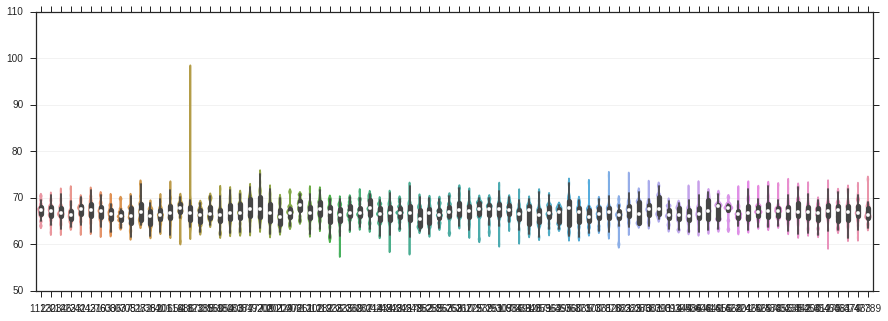

kmer AAAAC
>>genomic_positions 125
>>total_events 6535


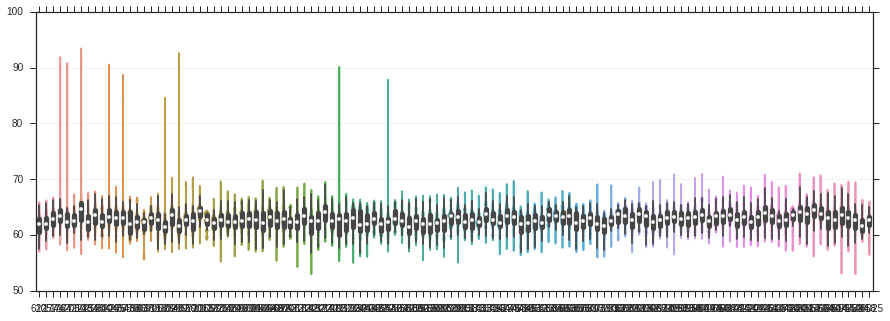

kmer AAAAG
>>genomic_positions 74
>>total_events 1726


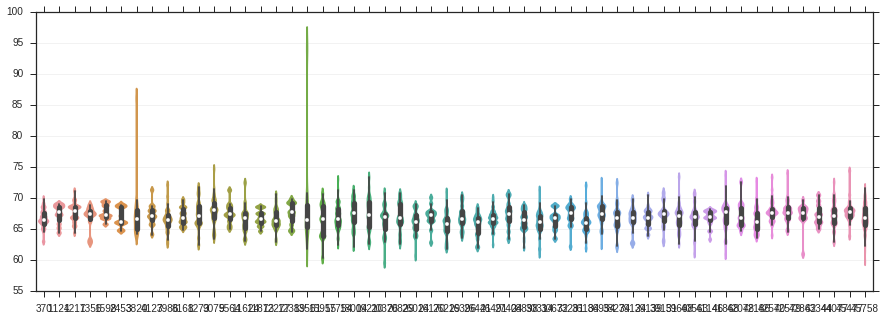

kmer AAAAT
>>genomic_positions 86
>>total_events 3341


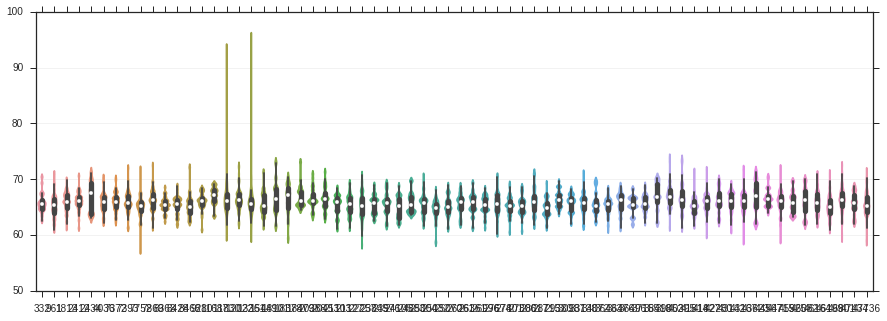

kmer AAACA
>>genomic_positions 82
>>total_events 5261


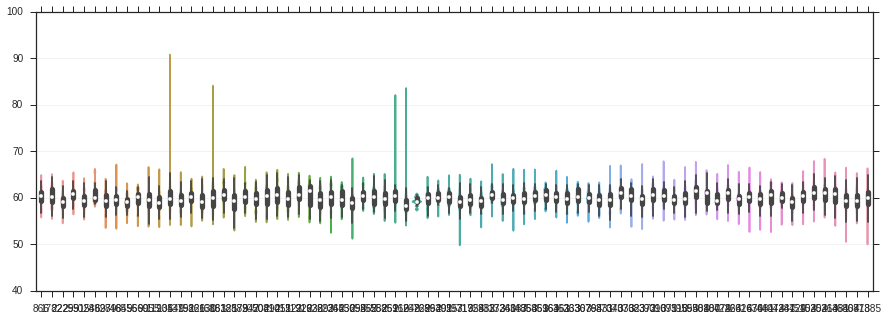

kmer AAACC
>>genomic_positions 68
>>total_events 4629


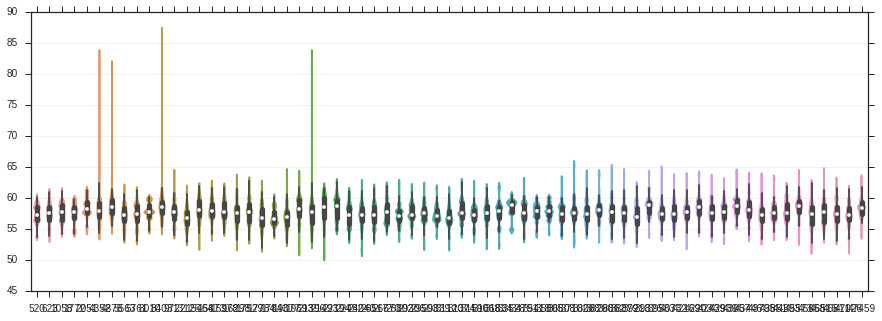

kmer AAACG
>>genomic_positions 77
>>total_events 5468


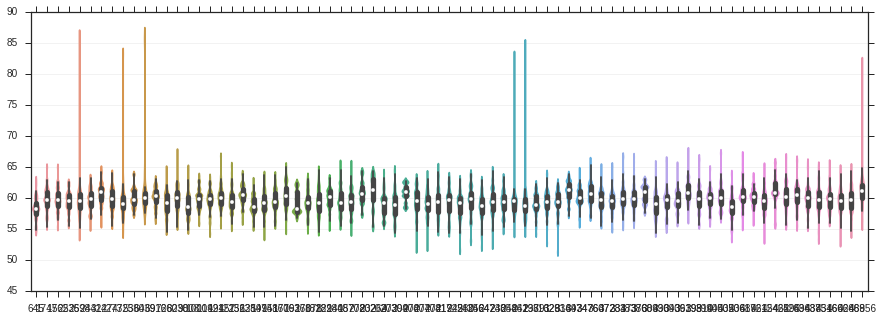

kmer AAACT
>>genomic_positions 48
>>total_events 3053


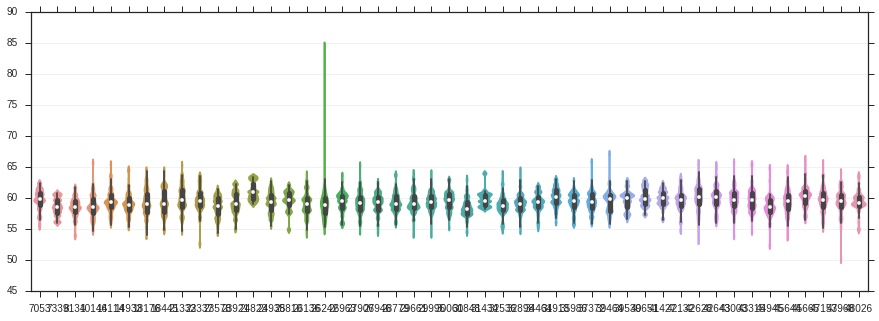

kmer AAAGA
>>genomic_positions 87
>>total_events 3586


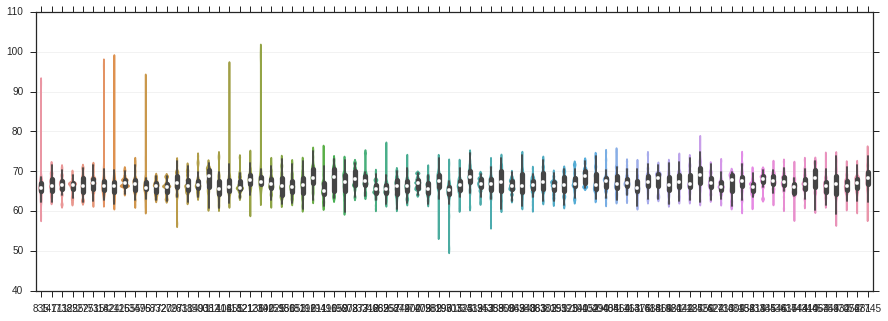

kmer AAAGC
>>genomic_positions 71
>>total_events 3562


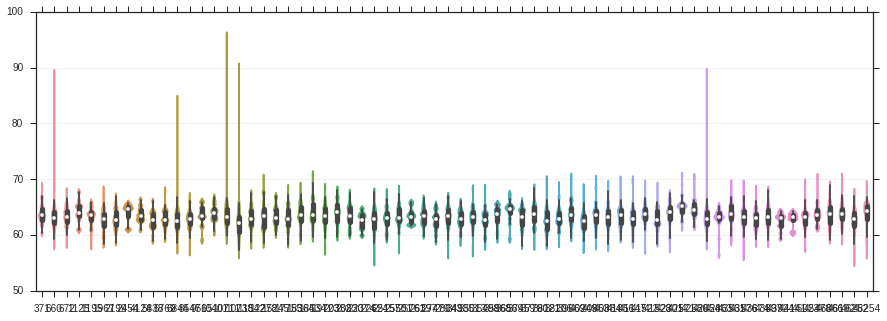

kmer AAAGG
>>genomic_positions 60
>>total_events 2220


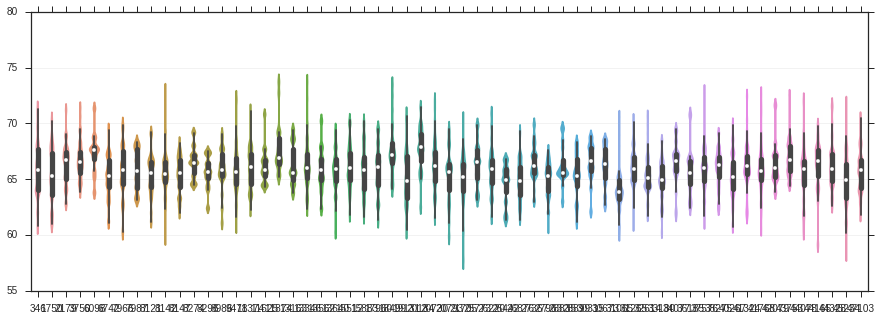

kmer AAAGT
>>genomic_positions 41
>>total_events 1868


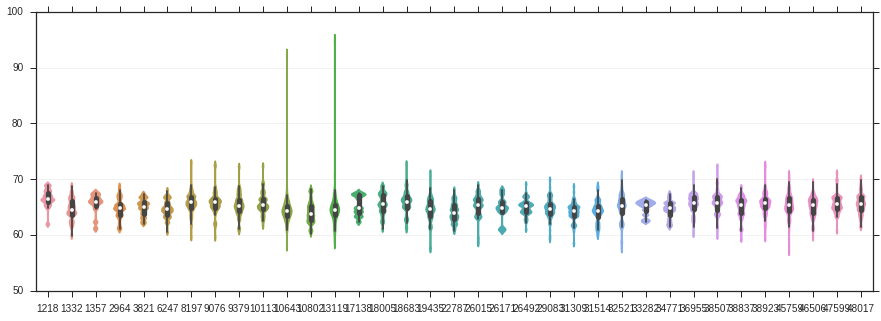

kmer AAATA
>>genomic_positions 70
>>total_events 4796


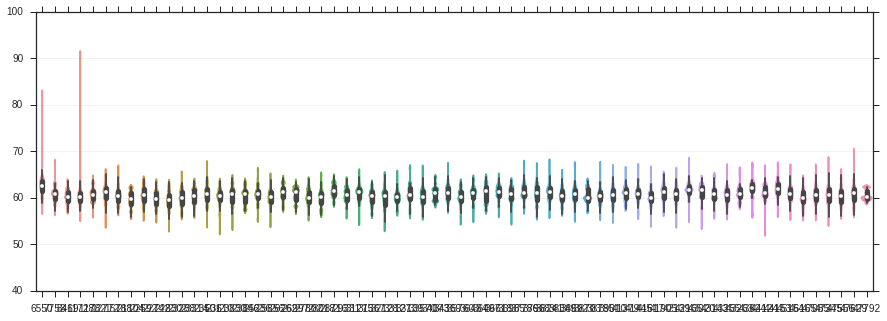

kmer AAATC
>>genomic_positions 75
>>total_events 5350


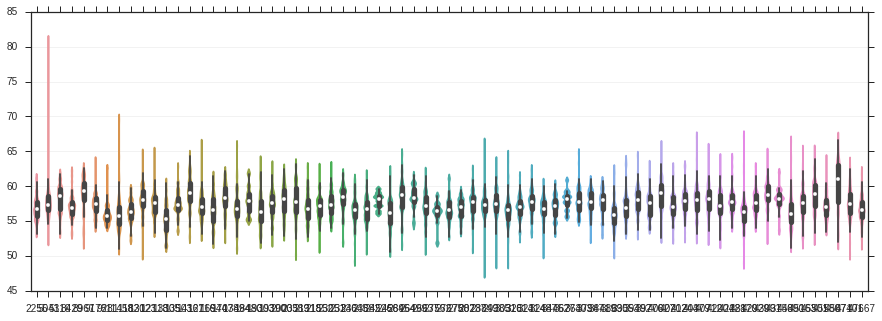

kmer AAATG
>>genomic_positions 68
>>total_events 4339


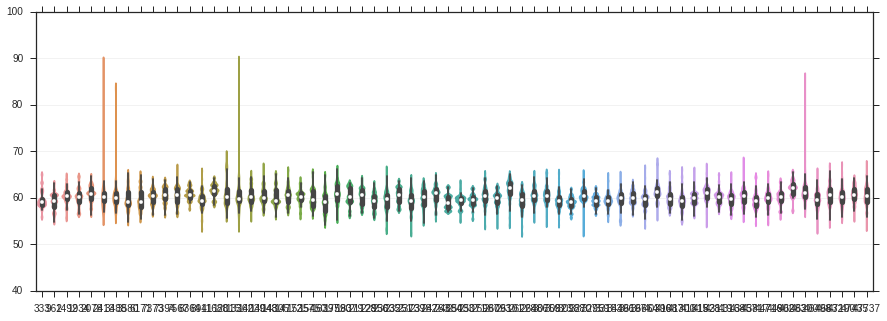

kmer AAATT
>>genomic_positions 63
>>total_events 4315


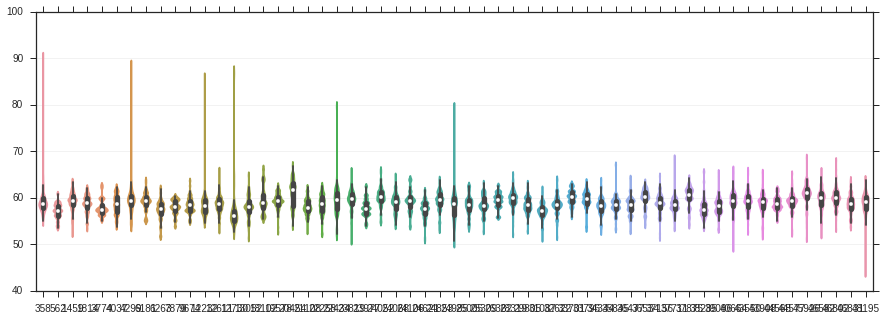

kmer AACAA
>>genomic_positions 71
>>total_events 6056


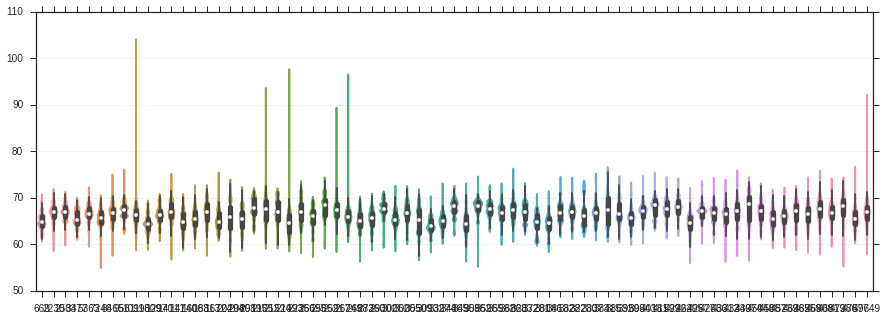

kmer AACAC
>>genomic_positions 42
>>total_events 2838


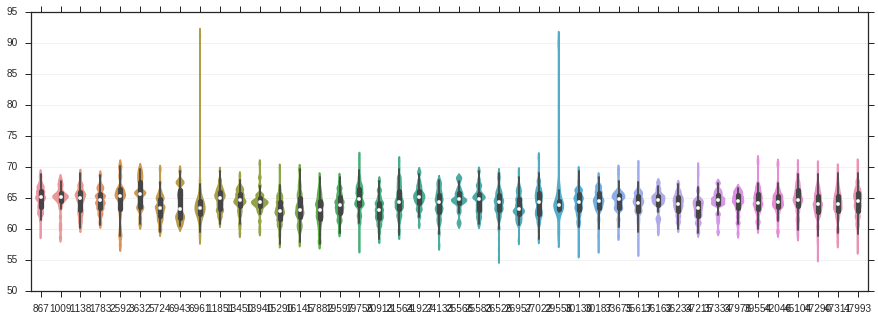

kmer AACAG
>>genomic_positions 87
>>total_events 6250


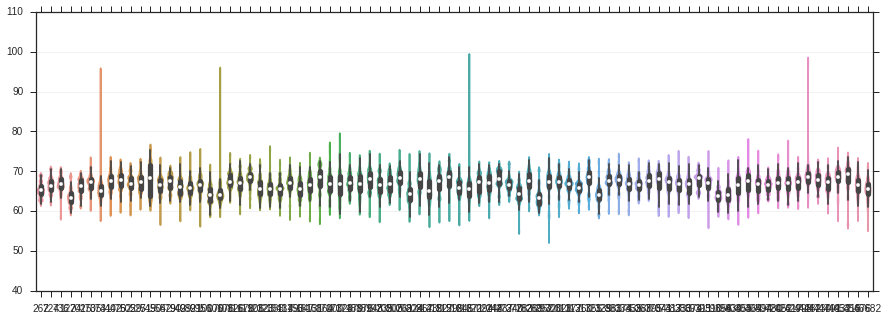

kmer AACAT
>>genomic_positions 52
>>total_events 4178


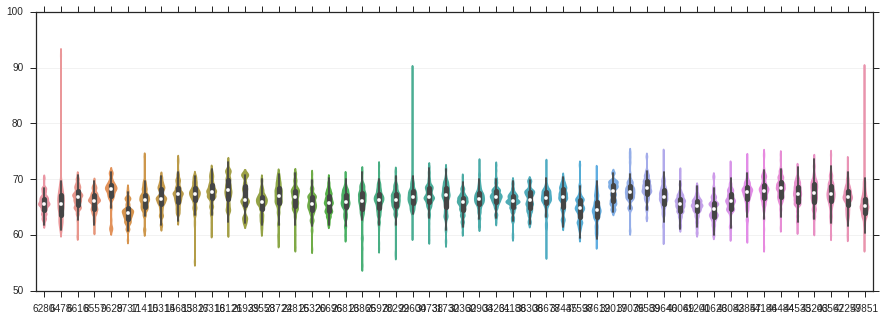

kmer AACCA
>>genomic_positions 55
>>total_events 4127


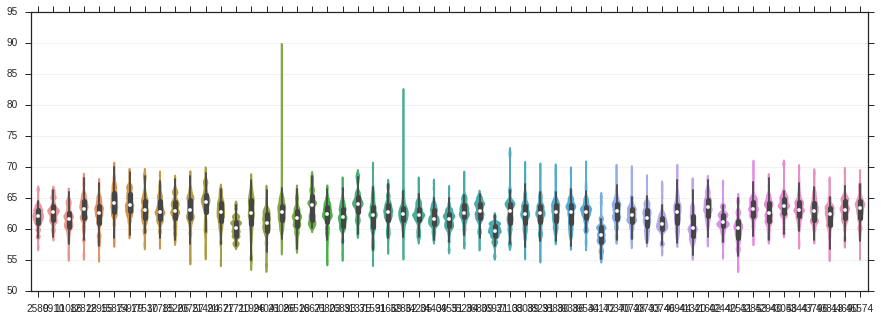

kmer AACCC
>>genomic_positions 36
>>total_events 1900


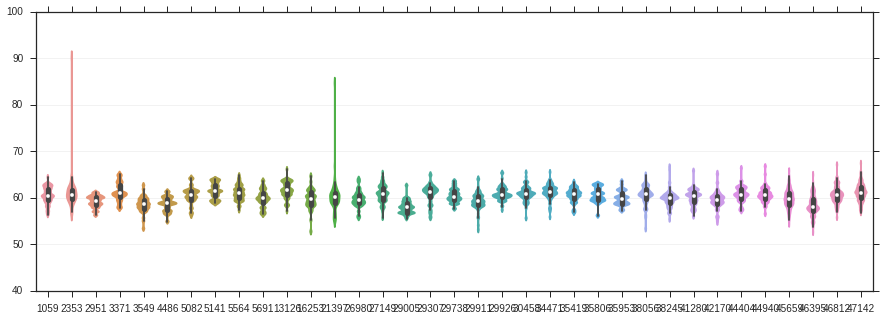

kmer AACCG
>>genomic_positions 62
>>total_events 3826


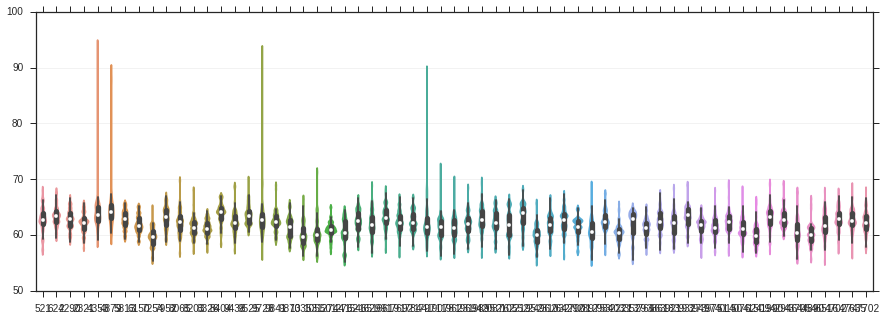

kmer AACCT
>>genomic_positions 41
>>total_events 2595


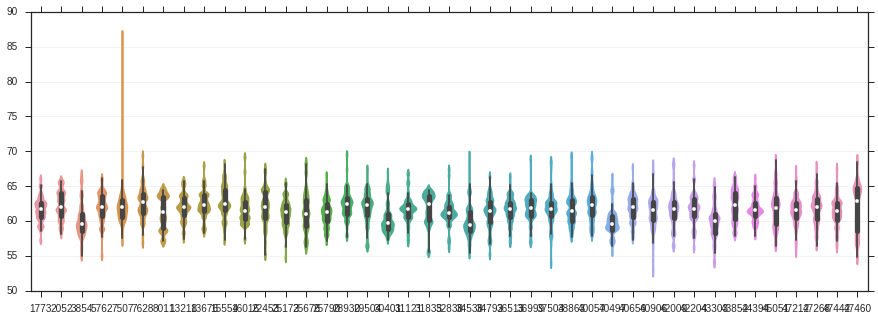

kmer AACGA
>>genomic_positions 57
>>total_events 4509


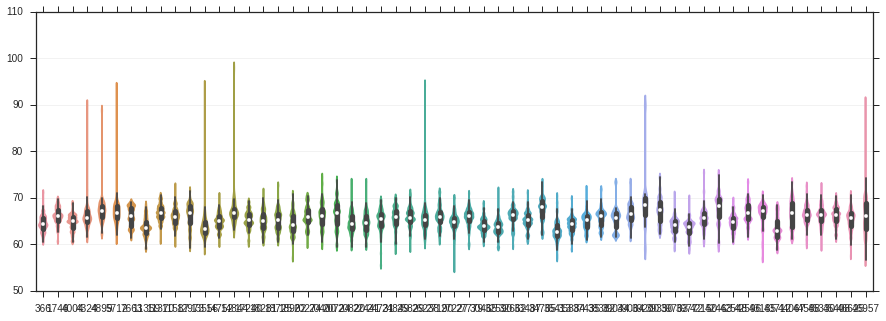

kmer AACGC
>>genomic_positions 57
>>total_events 4196


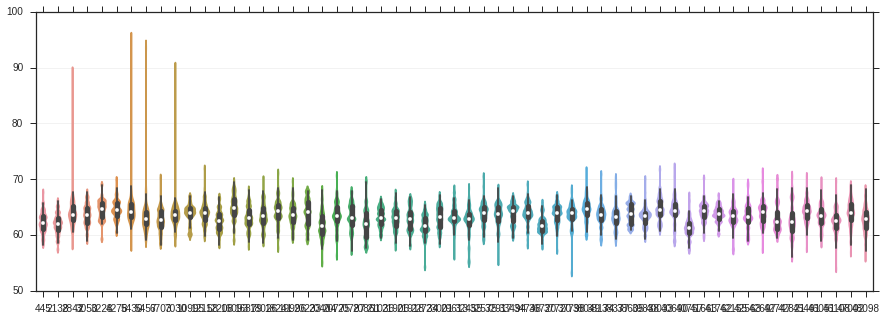

kmer AACGG
>>genomic_positions 66
>>total_events 4430


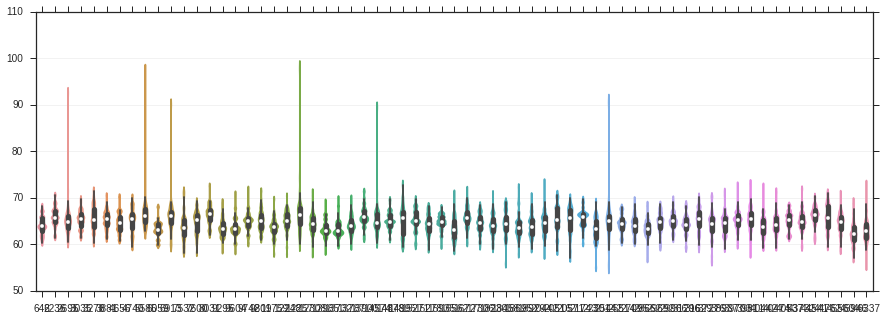

kmer AACGT
>>genomic_positions 40
>>total_events 3456


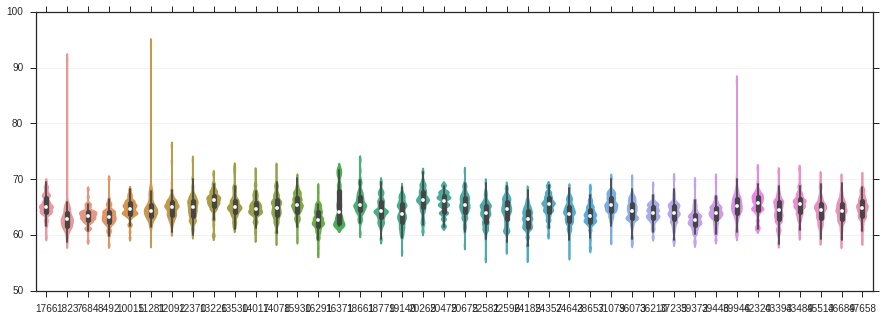

kmer AACTA
>>genomic_positions 23
>>total_events 1133


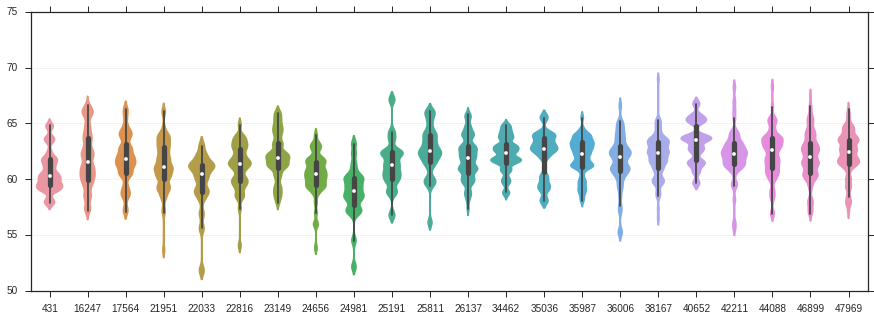

kmer AACTC
>>genomic_positions 44
>>total_events 1583


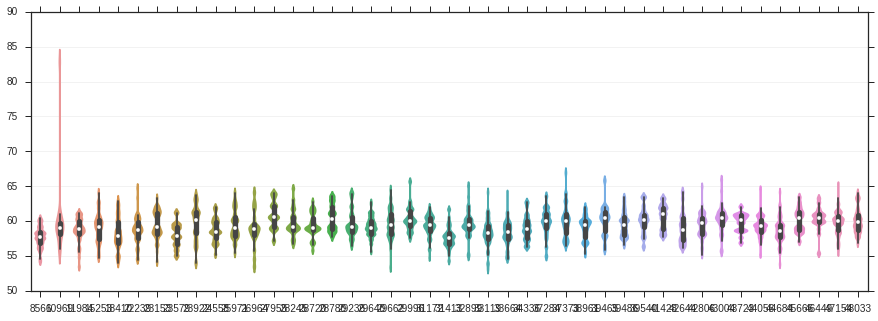

kmer AACTG
>>genomic_positions 78
>>total_events 3498


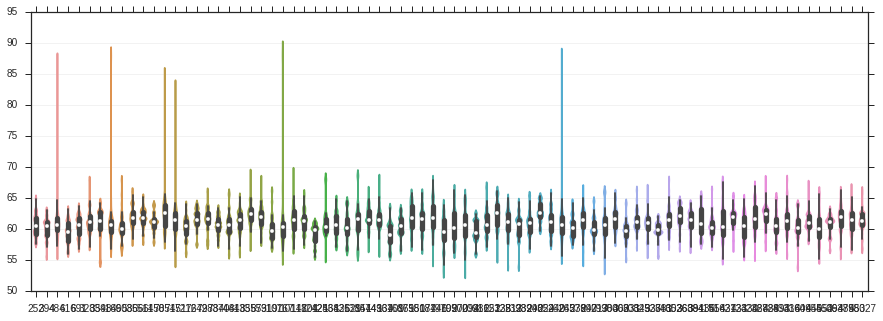

In [ ]:
for kmer in ev_map.keys():
    fig, ax = subplots(figsize=(15,5))
    template_events = prepare_events(kmer)
    genomic_pos = stratify_by_position(template_events)
    means = [x["mean"] for pos, x in genomic_pos.items()]
#     sns.violinplot(means, bw=.15)
    mlen = np.max([len(x["event_means"]) for x in genomic_pos.values()])
    d = {pos: x["event_means"] + [np.nan for _ in range(len(x["event_means"]), mlen)] for pos, x in genomic_pos.items()}
    sns.violinplot(data=pandas.DataFrame(d), bw=0.15, ax=ax)
    display(fig)
    plt.close()